# Лабораторная работа №3

_Выполнили: Гуревич Михаил и Трохан Александр, M32001_

## Подготовка

Вспомогательные функции

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from types import FunctionType


PHI = (1 + np.sqrt(5)) / 2  # Золотое сечение


def golden_section(f: FunctionType, left, right, epsilon):
    while right - left > epsilon:
        delta = (right - left) / PHI
        x_1 = right - delta
        x_2 = left + delta

        if f(x_1) < f(x_2):
            right = x_2
        else:
            left = x_1
        
    return (left + right) / 2


def plot_axis_3d(ax, x, y, z, title, colormap=cm.coolwarm):
    ax.plot_surface(x, y, z, cmap=colormap)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title)

Класс для квадратичной функции

In [2]:
class QuadraticFunction:
    def __init__(self, a, b, c=0):
        self.a = a
        self.b = b
        self.c = c

    @staticmethod
    def from_coefficients(x2, y2, xy, x, y, c):
        # xy / 2 - чтобы не учитывать дважды при сложении
        a = np.array([[x2, xy / 2], [xy / 2, y2]])
        b = np.array([x, y])
        return QuadraticFunction(a, b, c)
    
    def coefficients(self):
        return self.a[0, 0], self.a[1, 1], self.a[0, 1] * 2, self.b[0], self.b[1], self.c

    def __call__(self, point: np.ndarray) -> np.number:
        # @ - оператор матричного умножения
        return point @ self.a @ point.T + self.b @ point.T + self.c

    def gradient(self, point: np.ndarray):
        # т.к. матрица A симметрична, то градиент можно вычислить следующим образом:
        return 2 * self.a @ point.T + self.b
    
    def dimensions(self):
        return self.a.shape[0]
    
    def __str__(self):
        if self.dimensions() == 2:
            return f"{self.a[0, 0]}x^2 + {self.a[0, 1] * 2}xy + {self.a[1, 1]}y^2 + {self.b[0]}x + {self.b[1]}y + {self.c}"
        return f"A: {self.a}\nB: {self.b}\nC: {self.c}"

In [3]:
def plot_3d(x, y, z, title, colormap=cm.coolwarm):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    plot_axis_3d(ax, x, y, z, title, colormap)
    plt.show()


def plot_trajectory_3d(x, y, z, title, colormap=cm.coolwarm):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    plot_axis_3d(ax, x, y, z, title, colormap)
    ax.plot(x, y, z, color="black")
    plt.show()

## Реализация алгоритмов

### Градиентный спуск с постоянным шагом


In [4]:
def gradiend_descent(f: QuadraticFunction, x_0, step, epsilon, max_iterations=2e6):
    x_values = [x_0]
    f_values = [f(x_0)]
    for _ in range(int(max_iterations)):
        x = x_values[-1]
        grad = f.gradient(x)
        if np.linalg.norm(grad) < epsilon:
            break
        x_values.append(x - step * grad)
        f_values.append(f(x_values[-1]))
    else:
        print("Maximum number of iterations exceeded")

    return x_values, f_values

### Градиентный спуск с дроблением шага по правилу Армихо

In [5]:
def gradiend_descent_armijo(f: QuadraticFunction, x_0, step, epsilon, max_iterations=2e6, armijo_coef=0.5):
    x_values = [x_0]
    f_values = [f(x_0)]
    for _ in range(int(max_iterations)):
        x = x_values[-1]
        grad = f.gradient(x)
        if np.linalg.norm(grad) < epsilon:
            break
        # уменьшаем шаг, пока не выполнится условие Армихо: f(x) - f(x - step * grad) >= armijo_coef * step * np.linalg.norm(grad) ** 2
        while f(x) - f(x - step * grad) < armijo_coef * step * np.linalg.norm(grad) ** 2:
            step /= 2
        x_values.append(x - step * grad)
        f_values.append(f(x_values[-1]))
    else:
        print("Maximum number of iterations exceeded")

    return x_values, f_values

### Метод наискорейшего спуска
В качестве метода одномерной оптимизации использован метод Золотого сечения.

In [6]:
def steepest_gradiend_descent(f: QuadraticFunction, x_0, epsilon, max_iterations=2e6):
    x_values = [x_0]
    f_values = [f(x_0)]
    for _ in range(int(max_iterations)):
        x = x_values[-1]
        grad = f.gradient(x)
        if np.linalg.norm(grad) < epsilon:
            break
        # ищем оптимальный шаг методом золотого сечения
        step = golden_section(lambda step, x=x, grad=grad: f(x - step * grad), 0, 1, epsilon)
        x_values.append(x - step * grad)
        f_values.append(f(x_values[-1]))
    else:
        print("Maximum number of iterations exceeded")

    return x_values, f_values

### Метод сопряженных градиентов

In [7]:
def conjugate_gradient(f: QuadraticFunction, x_0, epsilon, max_iterations=2e6):
    x_values = [x_0]
    f_values = [f(x_0)]
    for _ in range(int(max_iterations)):
        x = x_values[-1]
        grad = f.gradient(x)
        if np.linalg.norm(grad) < epsilon:
            break
        # вместо градиента берем направление, образуемое предыдущим и текущим градиентами
        if len(x_values) > 1:
            prev_grad = f.gradient(x_values[-2])
            beta = np.linalg.norm(grad) ** 2 / np.linalg.norm(prev_grad) ** 2
            grad = grad + beta * prev_grad
        # ищем оптимальный шаг методом золотого сечения
        step = golden_section(lambda step, x=x, grad=grad: f(x - step * grad), 0, 1, epsilon)
        x_values.append(x - step * grad)
        f_values.append(f(x_values[-1]))
    else:
        print("Maximum number of iterations exceeded")

    return x_values, f_values

## Тестирование

### Выбор квадратичных функций

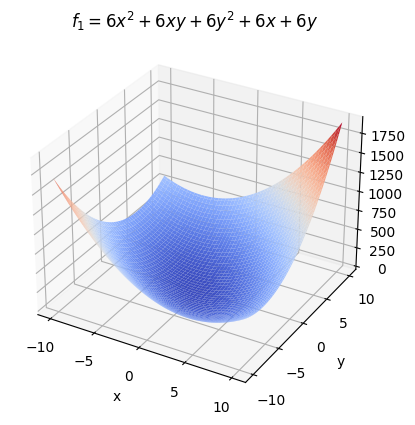

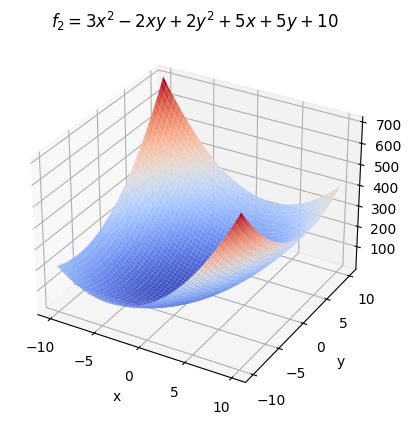

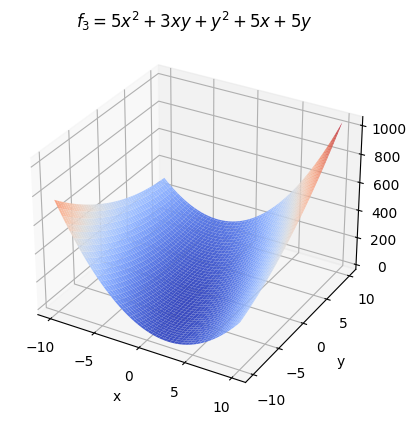

In [8]:
def plot_quadratic_function(f: QuadraticFunction, title):
    X, Y = np.mgrid[-10:10:100j, -10:10:100j]
    x2, y2, xy, x, y, c = f.coefficients()
    F = x2 * X ** 2 + xy * X * Y + y2 * Y ** 2 + x * X + y * Y + c
    plot_3d(X, Y, F, title)

f1 = QuadraticFunction.from_coefficients(6, 6, 6, 6, 6, 0)
plot_quadratic_function(f1, "$f_1 = 6x^2 + 6xy + 6y^2 + 6x + 6y$")

f2 = QuadraticFunction.from_coefficients(3, 2, -2, 5, 5, 10)
plot_quadratic_function(f2, "$f_2 = 3x^2 - 2xy + 2y^2 + 5x + 5y + 10$")

f3 = QuadraticFunction.from_coefficients(5, 1, 3, 7, 7, 0)
plot_quadratic_function(f3, "$f_3 = 5x^2 + 3xy + y^2 + 5x + 5y$")

### Анализ работы алгоритмов

In [9]:
def trajectory(f: QuadraticFunction, var_values, f_values, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    X, Y = np.mgrid[-10:10:100j, -10:10:100j]
    x2, y2, xy, x, y, c = f.coefficients()
    F = x2 * X ** 2 + xy * X * Y + y2 * Y ** 2 + x * X + y * Y + c

    plot_axis_3d(ax, X, Y, F, title)
    ax.plot([x[0] for x in var_values], [x[1] for x in var_values], f_values, color="red", zorder=10)
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    levels = ax.contourf(X, Y, F, cmap=cm.coolwarm)
    fig.colorbar(levels, ax=ax)
    for i in range(len(var_values) - 1):
        ax.arrow(var_values[i][0], var_values[i][1], var_values[i + 1][0] - var_values[i][0],
                    var_values[i + 1][1] - var_values[i][1],
                    head_width=0.3, head_length=0.3, length_includes_head=True, color="red")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title)
    plt.show()


def analyze_function(f: QuadraticFunction, func_name):
    grad_var_values, grad_f_values = gradiend_descent(f, x0, 0.1, 0.01)
    trajectory(f, grad_var_values, grad_f_values, "Градиентный спуск с постоянным шагом")
    armijo_var_values, armijo_f_values = gradiend_descent_armijo(f, x0, 0.1, 0.01)
    trajectory(f, armijo_var_values, armijo_f_values, "Градиентный спуск с условием Армихо")
    steepest_var_values, steepest_f_values = steepest_gradiend_descent(f, x0, 0.01)
    trajectory(f, steepest_var_values, steepest_f_values, "Наискорейший градиентный спуск")
    conj_var_values, conj_f_values = conjugate_gradient(f, x0, 0.01)
    trajectory(f, conj_var_values, conj_f_values, "Метод сопряженных градиентов")

    plt.plot(np.arange(len(grad_f_values)), grad_f_values, label="Градиентный спуск с постоянным шагом")
    plt.plot(np.arange(len(armijo_f_values)), armijo_f_values, label="Градиентный спуск с условием Армихо")
    plt.plot(np.arange(len(steepest_f_values)), steepest_f_values, label="Наискорейший градиентный спуск")
    plt.plot(np.arange(len(conj_f_values)), conj_f_values, label="Метод сопряженных градиентов")
    plt.legend()
    plt.xlabel("Номер итерации")
    plt.ylabel("Значение функции")
    plt.title(f"Сравнение методов на функции ${func_name}$")
    plt.show()


# Выберем одну начальную точку для всех методов и функий
x0 = np.random.uniform(-1, 1, 2) * 10
print("Начальная точка:", x0)

Начальная точка: [ 0.43395913 -3.56836719]


Функция $f_1(x, y) = 6x^2 + 6xy + 6y^2 + 6x + 6y$:

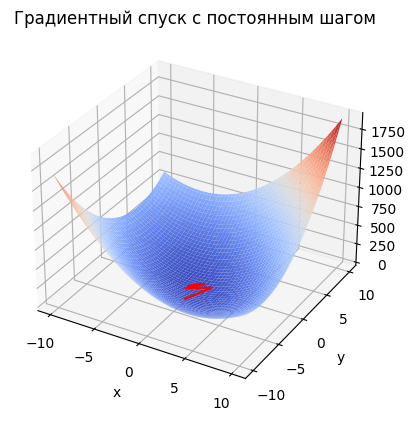

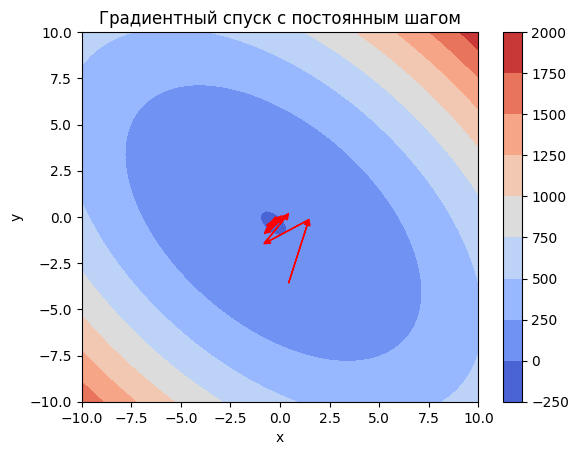

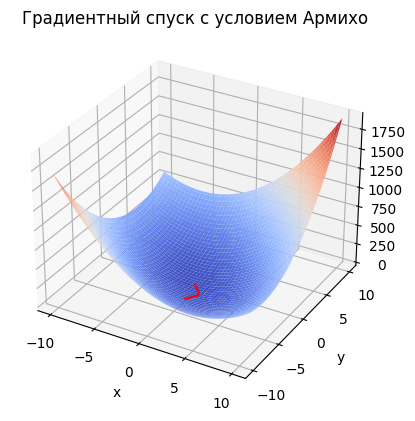

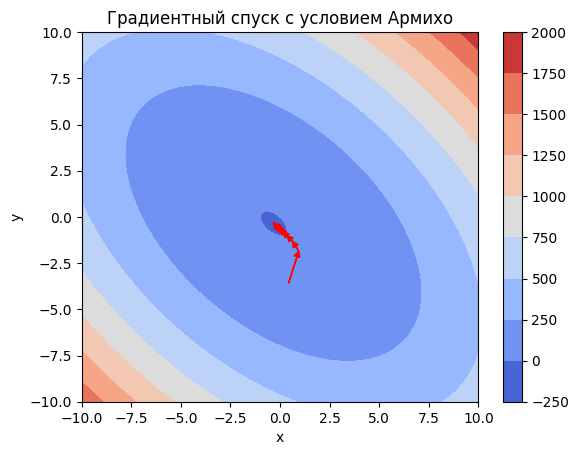

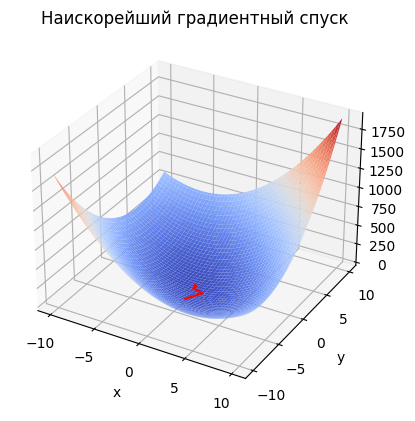

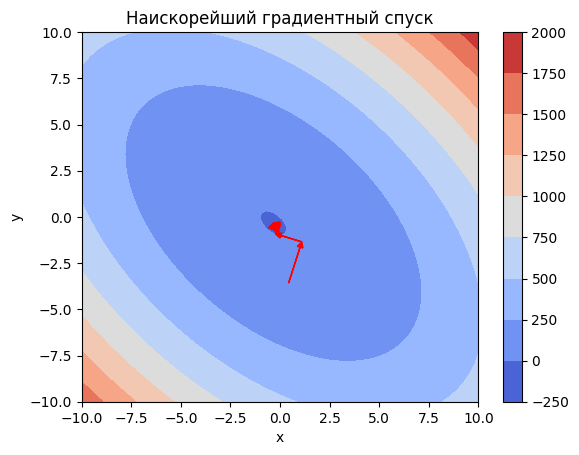

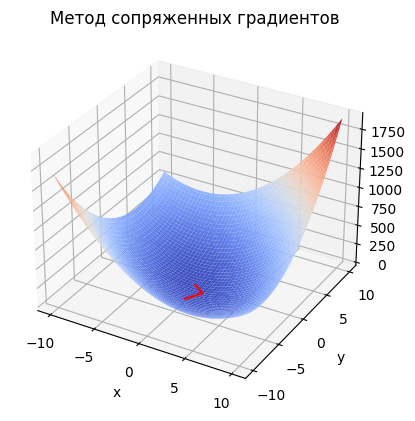

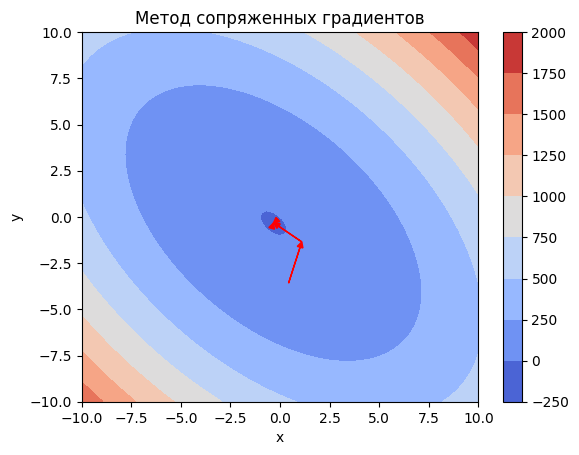

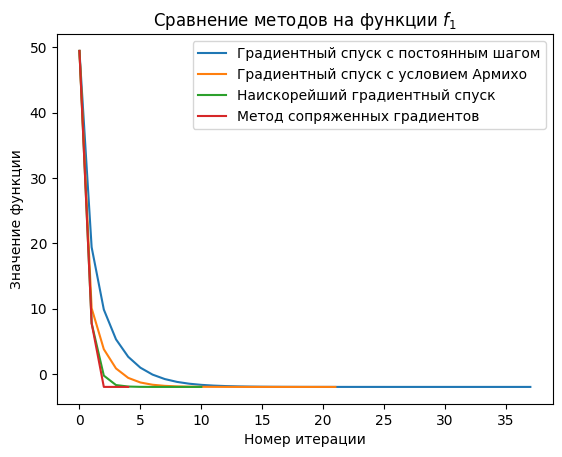

In [10]:
analyze_function(f1, "f_1")

Функция $f_2(x, y) = 3x^2 - 2xy + 2y^2 + 5x + 5y + 10$:

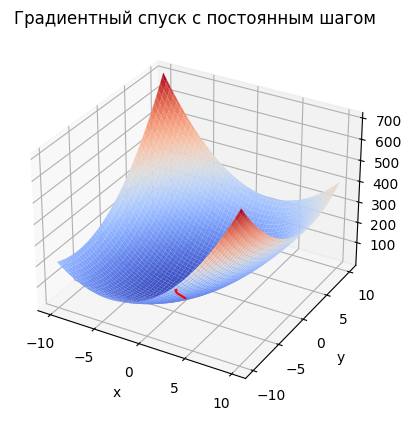

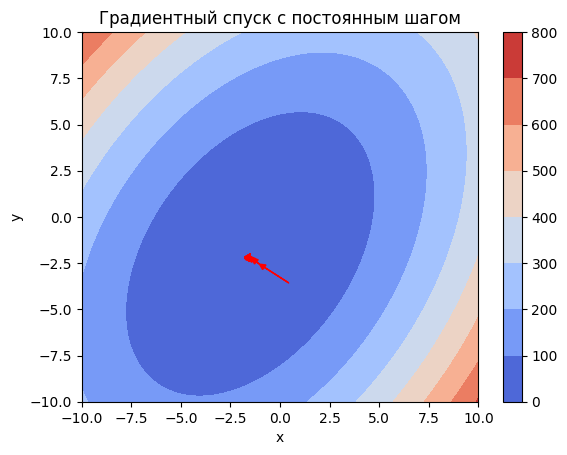

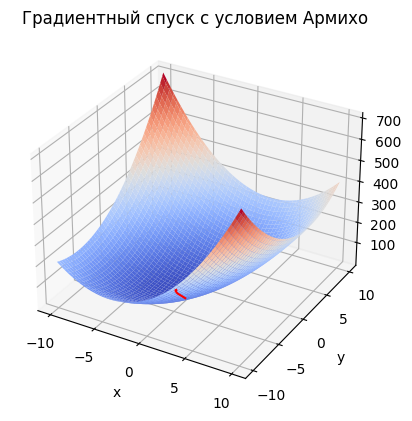

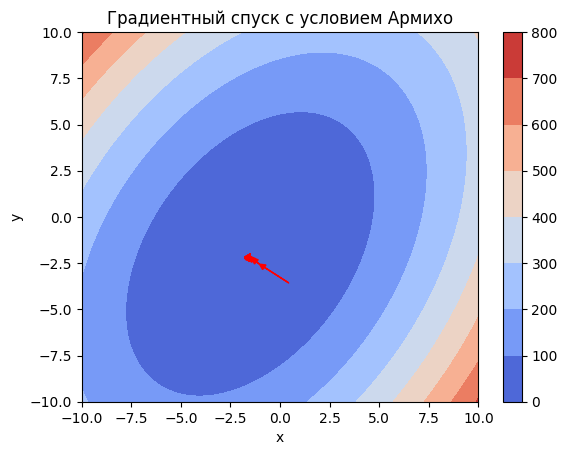

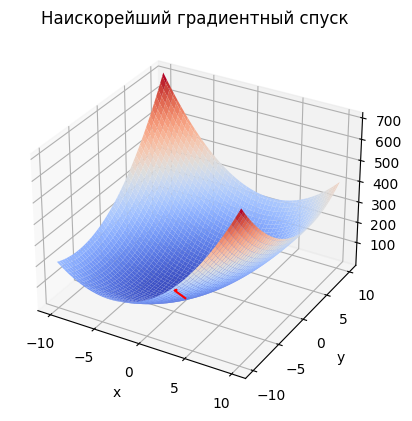

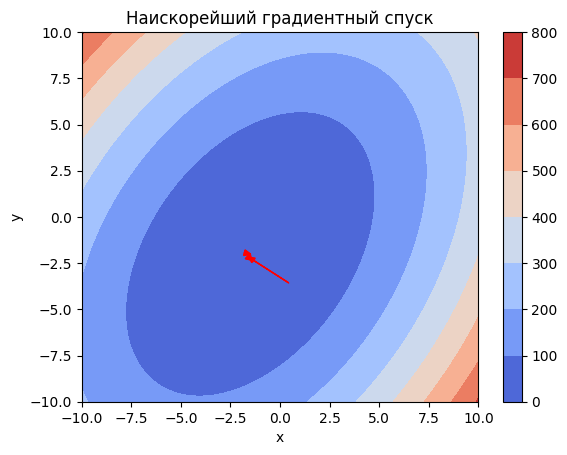

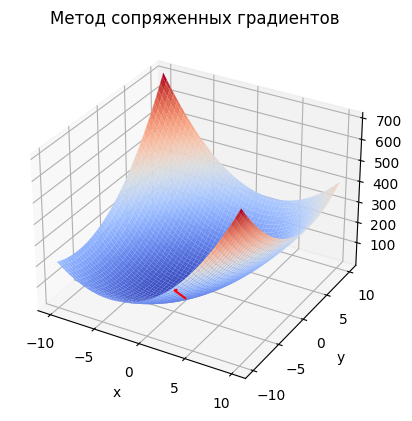

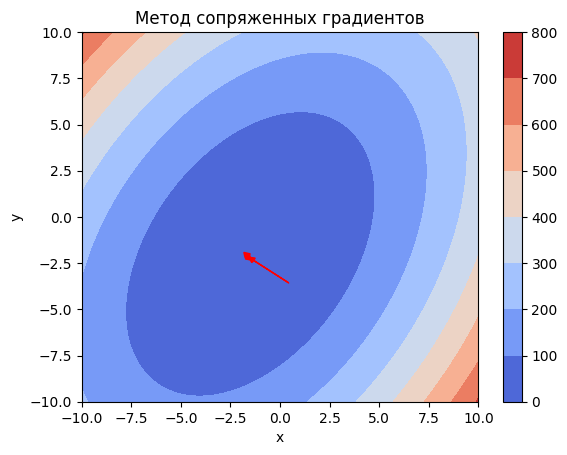

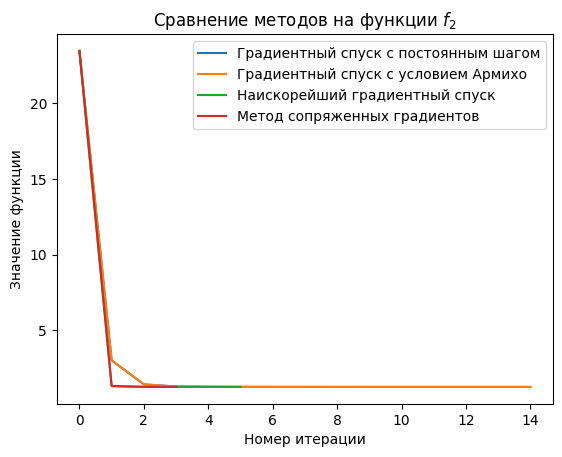

In [11]:
analyze_function(f2, "f_2")

Функция $f_3(x, y) = 5x^2 + 3xy + y^2 + 7x + 7y$:

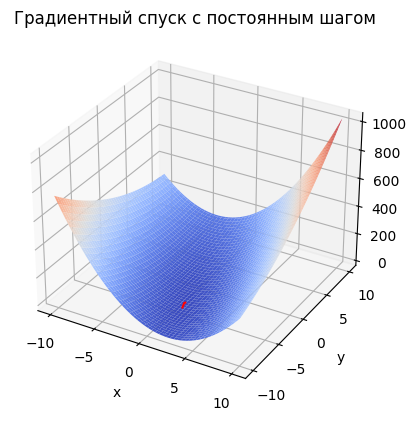

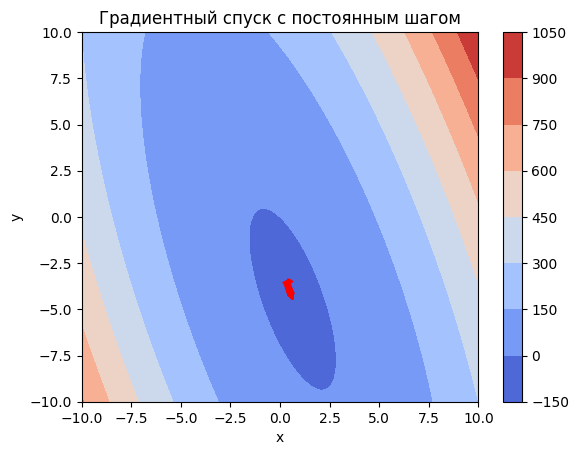

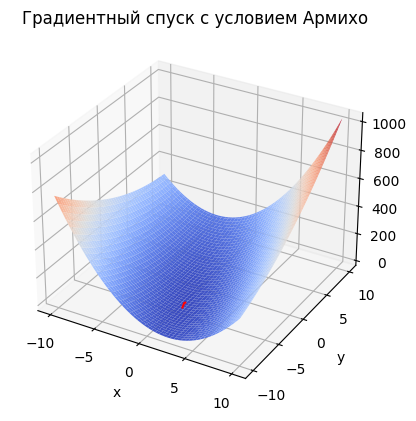

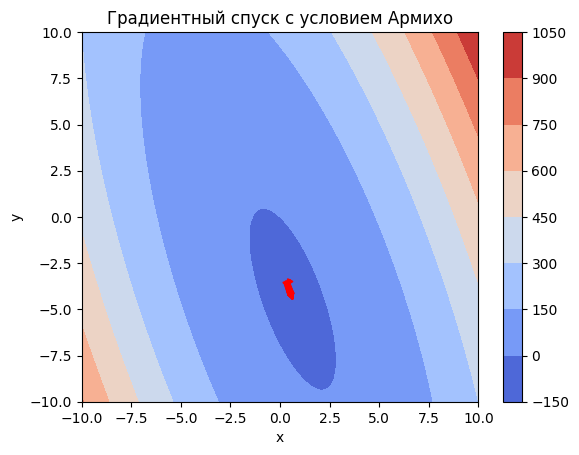

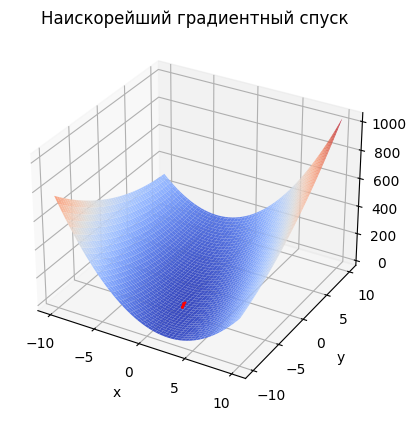

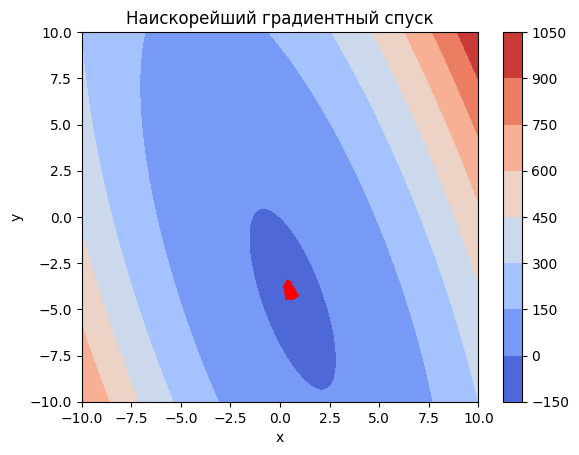

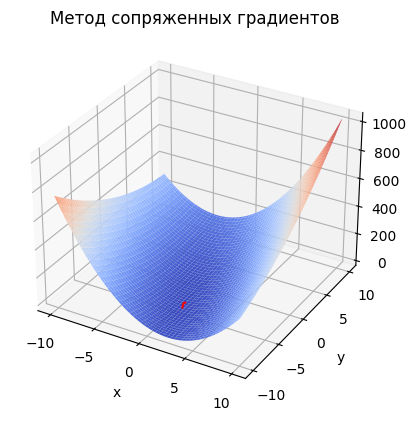

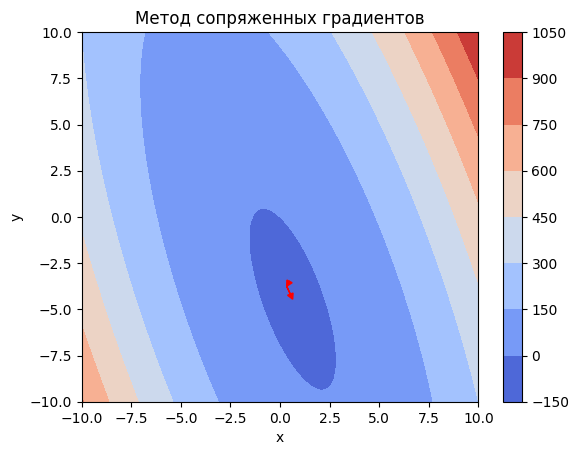

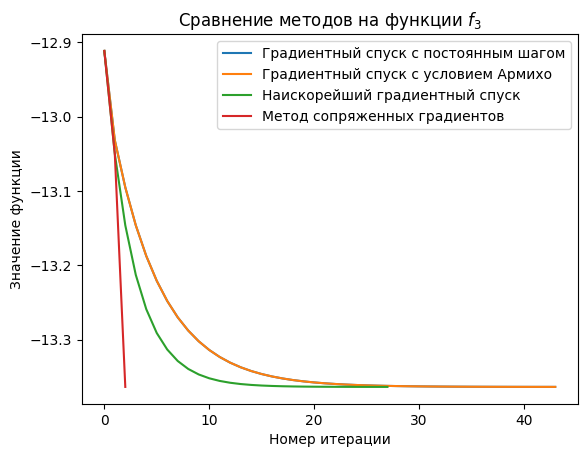

In [12]:
analyze_function(f3, "f_3")

### Зависимость сходимости методов от выбора начальной точки

In [13]:
def plot_iterations(staring_points, iterations, real_minimum, title, color):
    plt.plot(np.linalg.norm(staring_points - real_minimum, axis=1), iterations, color=color)
    plt.xlabel("Расстояние от начальной точки до точки минимума")
    plt.ylabel("Количество итераций")
    plt.title(title)
    plt.show()

Рассмотрим работу методов на функции $f_1$, минимум которой находится в точке $x^* = (-\dfrac{1}{3}, -\dfrac{1}{3})$.

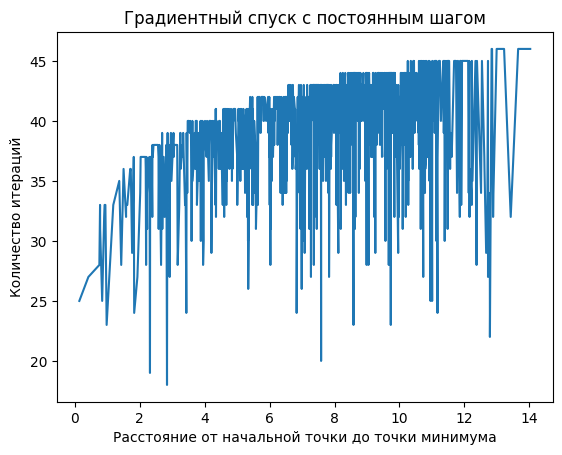

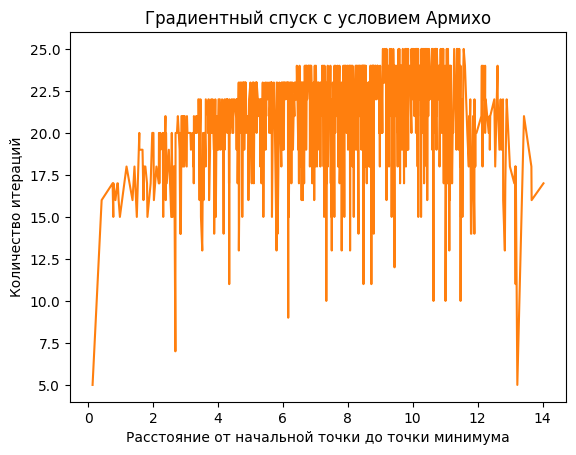

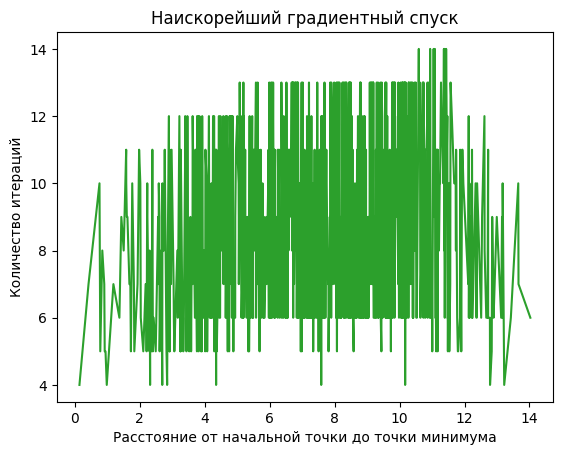

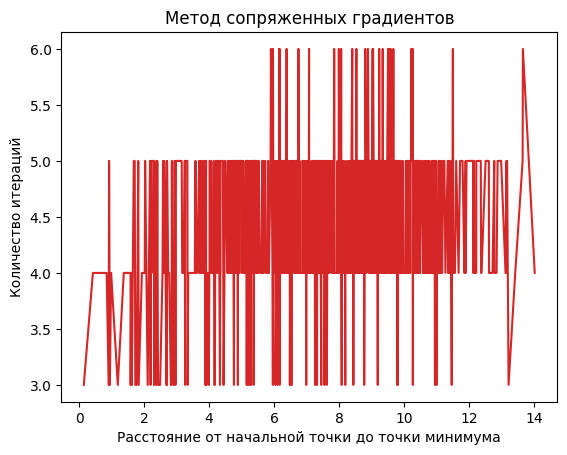

In [14]:
MINIMUM = np.array([-1 / 3, -1 / 3])

staring_points = np.random.uniform(-1, 1, (1000, 2)) * 10
staring_points = staring_points[np.argsort(np.linalg.norm(staring_points - MINIMUM, axis=1))]

grad_iterations = np.zeros(1000)
armijo_iterations = np.zeros(1000)
steepest_iterations = np.zeros(1000)
conj_iterations = np.zeros(1000)
for i in range(1000):
    grad_iterations[i] = len(gradiend_descent(f1, staring_points[i], 0.1, 0.01)[0]) - 1
    armijo_iterations[i] = len(gradiend_descent_armijo(f1, staring_points[i], 0.1, 0.01)[0]) - 1
    steepest_iterations[i] = len(steepest_gradiend_descent(f1, staring_points[i], 0.01)[0]) - 1
    conj_iterations[i] = len(conjugate_gradient(f1, staring_points[i], 0.01)[0]) - 1

plot_iterations(staring_points, grad_iterations, MINIMUM, "Градиентный спуск с постоянным шагом", color="tab:blue")
plot_iterations(staring_points, armijo_iterations, MINIMUM, "Градиентный спуск с условием Армихо", color="tab:orange")
plot_iterations(staring_points, steepest_iterations, MINIMUM, "Наискорейший градиентный спуск", color="tab:green")
plot_iterations(staring_points, conj_iterations, MINIMUM, "Метод сопряженных градиентов", color="tab:red")

Рассмотрим работу методов на функции $f_2$, минимум которой находится в точке $x^* = (-\dfrac{3}{2}, -2)$.

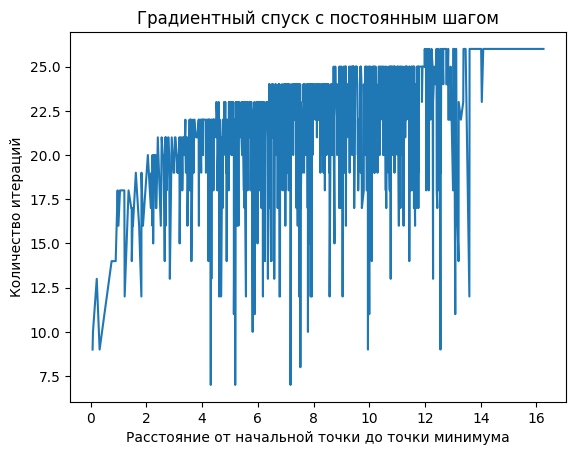

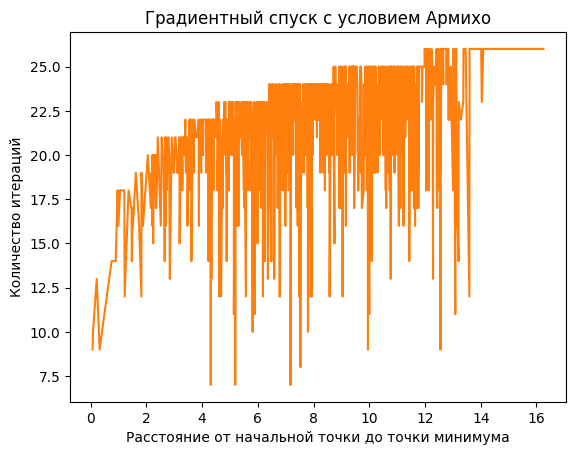

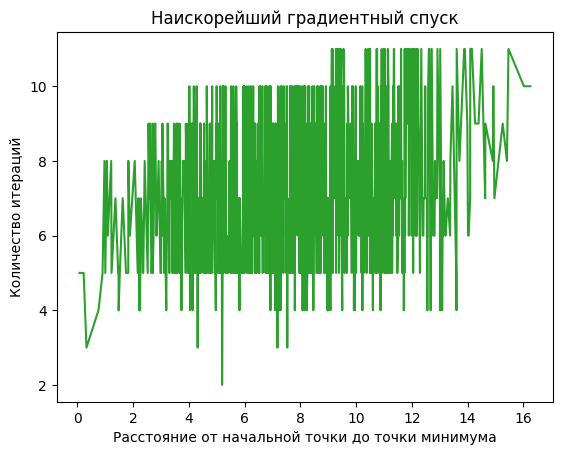

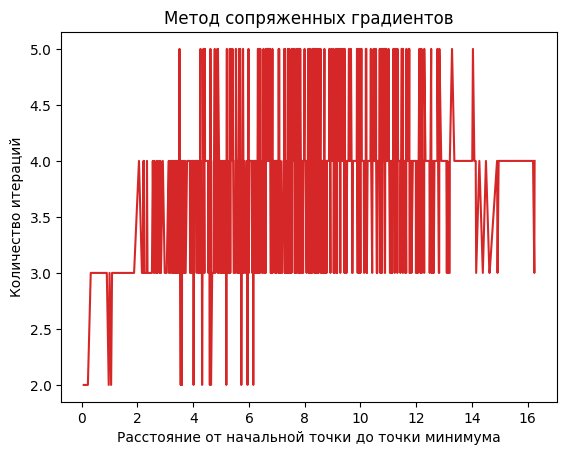

In [15]:
MINIMUM = np.array([-1.5, -2])

staring_points = np.random.uniform(-1, 1, (1000, 2)) * 10
staring_points = staring_points[np.argsort(np.linalg.norm(staring_points - MINIMUM, axis=1))]

grad_iterations = np.zeros(1000)
armijo_iterations = np.zeros(1000)
steepest_iterations = np.zeros(1000)
conj_iterations = np.zeros(1000)
for i in range(1000):
    grad_iterations[i] = len(gradiend_descent(f2, staring_points[i], 0.1, 0.01)[0]) - 1
    armijo_iterations[i] = len(gradiend_descent_armijo(f2, staring_points[i], 0.1, 0.01)[0]) - 1
    steepest_iterations[i] = len(steepest_gradiend_descent(f2, staring_points[i], 0.01)[0]) - 1
    conj_iterations[i] = len(conjugate_gradient(f2, staring_points[i], 0.01)[0]) - 1

plot_iterations(staring_points, grad_iterations, MINIMUM, "Градиентный спуск с постоянным шагом", color="tab:blue")
plot_iterations(staring_points, armijo_iterations, MINIMUM, "Градиентный спуск с условием Армихо", color="tab:orange")
plot_iterations(staring_points, steepest_iterations, MINIMUM, "Наискорейший градиентный спуск", color="tab:green")
plot_iterations(staring_points, conj_iterations, MINIMUM, "Метод сопряженных градиентов", color="tab:red")

Рассмотрим работу методов на функции $f_3$, минимум которой находится в точке $x^* = (\dfrac{7}{11}, -\dfrac{49}{11})$.

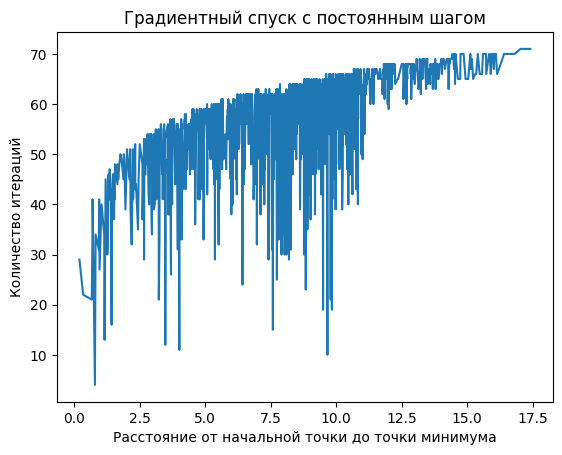

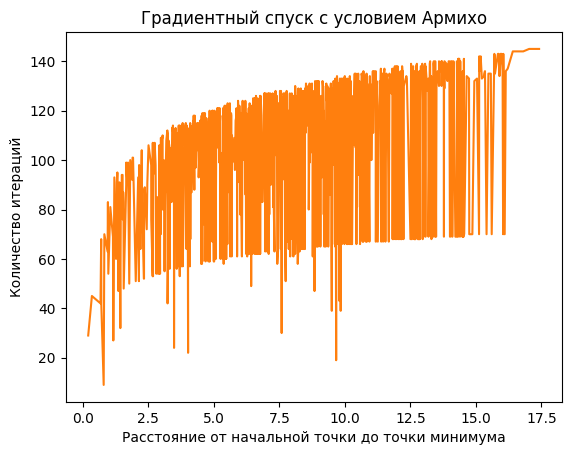

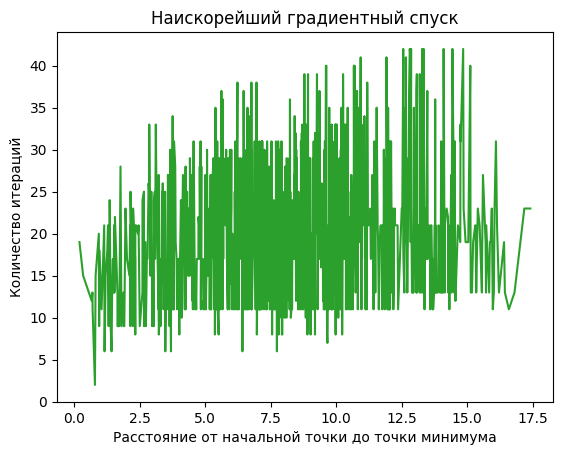

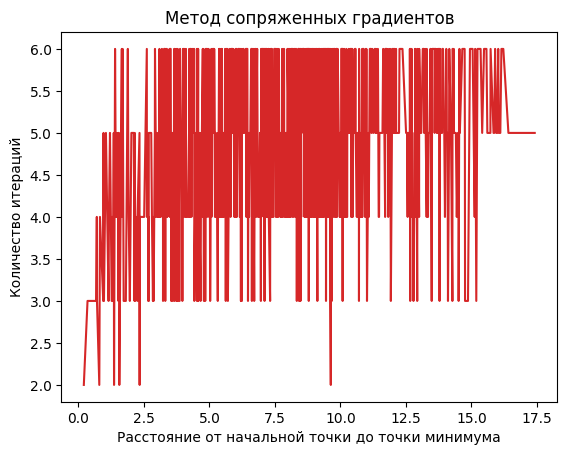

In [16]:
MINIMUM = np.array([7 / 11, -49 / 11])

staring_points = np.random.uniform(-1, 1, (1000, 2)) * 10
staring_points = staring_points[np.argsort(np.linalg.norm(staring_points - MINIMUM, axis=1))]

grad_iterations = np.zeros(1000)
armijo_iterations = np.zeros(1000)
steepest_iterations = np.zeros(1000)
conj_iterations = np.zeros(1000)
for i in range(1000):
    grad_iterations[i] = len(gradiend_descent(f3, staring_points[i], 0.1, 0.01)[0]) - 1
    armijo_iterations[i] = len(gradiend_descent_armijo(f3, staring_points[i], 0.1, 0.01)[0]) - 1
    steepest_iterations[i] = len(steepest_gradiend_descent(f3, staring_points[i], 0.01)[0]) - 1
    conj_iterations[i] = len(conjugate_gradient(f3, staring_points[i], 0.01)[0]) - 1

plot_iterations(staring_points, grad_iterations, MINIMUM, "Градиентный спуск с постоянным шагом", color="tab:blue")
plot_iterations(staring_points, armijo_iterations, MINIMUM, "Градиентный спуск с условием Армихо", color="tab:orange")
plot_iterations(staring_points, steepest_iterations, MINIMUM, "Наискорейший градиентный спуск", color="tab:green")
plot_iterations(staring_points, conj_iterations, MINIMUM, "Метод сопряженных градиентов", color="tab:red")

### Генератор случайных квадратичных функций
Данный метод генерирует только квадратичные функции с диагональными матрицами _(так разрешил Михаил Викторович)_.

In [17]:
def generate_quadratic(dimensions, condition_number):
    min_ = np.random.rand()
    max_ = min_ * condition_number
    scale = max_ - min_
    a = np.random.rand(dimensions, dimensions) * scale
    a = np.diag(np.diag(a))
    min_pos = np.random.randint(0, dimensions)
    max_pos = np.random.randint(0, dimensions)
    while min_pos == max_pos:
        max_pos = np.random.randint(0, dimensions)
    a[min_pos, min_pos] = min_
    a[max_pos, max_pos] = max_
    b = np.random.rand(dimensions) * scale
    c = np.random.rand() * scale
    return QuadraticFunction(a, b, c)

In [51]:
X = np.arange(2, 1000, 100)  # n
Y = np.arange(1, 1000, 100)  # k
Z = np.zeros((len(X), len(Y)))

for i in range(len(X)):
    for j in range(len(Y)):
        f = generate_quadratic(X[i], Y[j])
        x0 = np.random.uniform(-1, 1, X[i])
        Z[i, j] = len(gradiend_descent_armijo(f, x0, 0.1, 0.01)[0]) - 1
        print(X[i], Y[j], Z[i, j])

2 1 33.0
2 101 844.0
2 201 1688.0
2 301 1847.0
2 401 2784.0
2 501 2134.0
2 601 4885.0
2 701 7544.0
2 801 7566.0
2 901 6890.0
102 1 122.0
102 101 1400.0
102 201 1465.0
102 301 11419.0
102 401 3438.0
102 501 4447.0
102 601 4092.0
102 701 4752.0
102 801 6982.0
102 901 7142.0
202 1 33.0
202 101 1279.0
202 201 1625.0
202 301 2259.0
202 401 3417.0
202 501 3015.0
202 601 7404.0
202 701 5212.0
202 801 45208.0
202 901 48263.0
302 1 341.0
302 101 965.0
302 201 14128.0
302 301 7049.0
302 401 2821.0
302 501 5208.0
302 601 4167.0
302 701 4316.0
302 801 6287.0
302 901 3205.0
402 1 27.0
402 101 4640.0
402 201 6032.0
402 301 2802.0
402 401 3571.0
402 501 4944.0
402 601 4857.0
402 701 4399.0
402 801 8497.0
402 901 9398.0
502 1 47.0
502 101 7599.0
502 201 10159.0
502 301 8599.0
502 401 25701.0
502 501 8185.0
502 601 3723.0
502 701 8262.0
502 801 10770.0
502 901 8715.0
602 1 98.0
602 101 14872.0
602 201 26388.0
602 301 2247.0
602 401 113745.0
602 501 4038.0
602 601 4850.0
602 701 8800.0
602 801 7326.0
60

KeyboardInterrupt: 

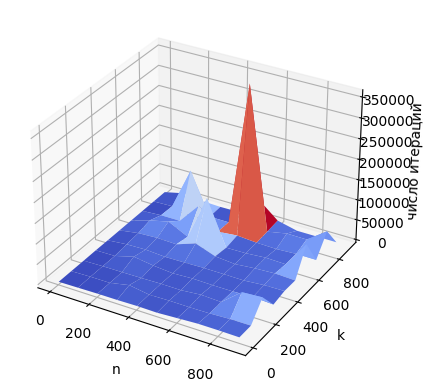

In [66]:
X, Y = np.meshgrid(X, Y)
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
ax.set_xlabel("n")
ax.set_ylabel("k")
ax.set_zlabel("число итераций")
plt.show()

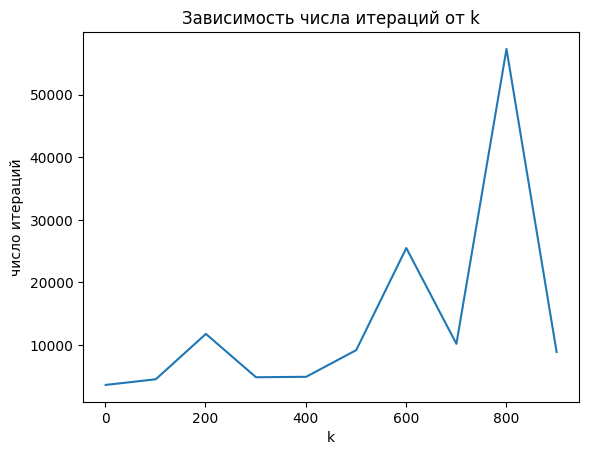

In [105]:
plt.plot(Y[:, 0], np.mean(Z, axis=1))
plt.xlabel("k")
plt.ylabel("число итераций")
plt.title("Зависимость числа итераций от k")
plt.show()

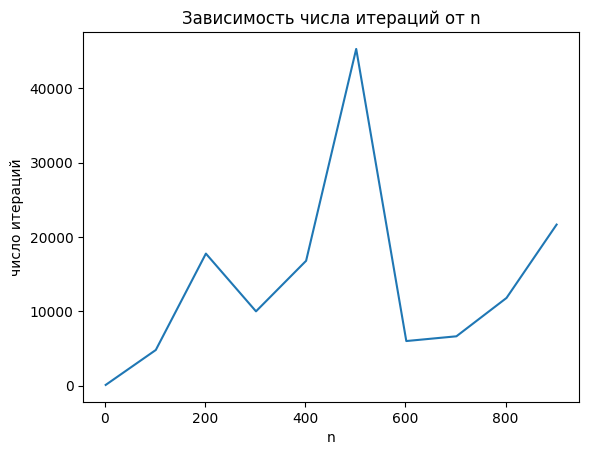

In [112]:
plt.plot(X[0], np.mean(Z, axis=0))
plt.xlabel("n")
plt.ylabel("число итераций")
plt.title("Зависимость числа итераций от n")
plt.show()